# HW2 Q4 (15 points). Transformation of 2-D data points with a neural network

In the example below, we use a randomly initialized neural network to transform data points. You can observe the distribution after the tranformation.

**Work to complete:** In the second part of this assignment, we have target distribution to approximate. How can you train a neural network to get such a pattern? Please provide a solution to this problem with the help of an LLM.


In particular, you need to complete the following three steps


1. (8 points) design your loss function. You need to work with a LLM to develop a loss function to train the neural network. Note that the loss function should take the following form: given a batch of training data:
```
X = torch.randn(batch_size, 2)
y = nn_func_elu(X)
```
There should be some function `loss(y, maybe_something_else)` defined on `y`.
The loss function returns a scalar value as the loss


2. (4 points). generate the training loop
If you have the loss function, then the training loop would be easy
The key step is only to back-propagate the gradient of the loss to model parameters and update them.


3. (3 points). plot the points from your function. Note that you need to draw new random samples and plot the transformed samples y. The pattern should be similar to the pattern above.


In [1]:
import torch
import matplotlib.pyplot as plt

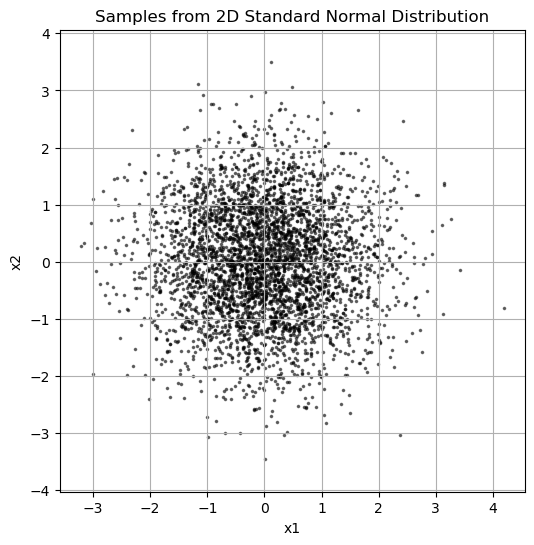

In [2]:
# Draw 1000 samples from a 2D standard normal distribution
X = torch.randn(4000, 2)

# Plot the data points
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, s=10, c='black', marker='.')
plt.title('Samples from 2D Standard Normal Distribution')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)
plt.axis('equal') # Set aspect ratio to 1:1
plt.show()

In [3]:
# You are given a two-layer neural network, but you can create your own one if you want

import torch.nn as nn

class TwoLayerNN(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super(TwoLayerNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128) # Hidden layer with 10 units
        self.layer2 = nn.Linear(128, 128) # Output layer
        self.layer3 = nn.Linear(128, output_dim) # Output layer

        if activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "elu":
            self.activation = nn.ELU()
        elif activation == "tanh":
            self.activation = nn.Tanh()
        else:
            self.activation = None # No activation

    def forward(self, x):
        x = self.layer1(x)
        if self.activation:
            x = self.activation(x)

        x = self.layer2(x)
        if self.activation:
            x = self.activation(x)
        x = self.layer3(x)

        return x

# Initialize the network with ReLU activation
nn_func_relu = TwoLayerNN(input_dim=2, output_dim=2, activation="relu")
nn_func_elu = TwoLayerNN(input_dim=2, output_dim=2, activation="elu")
nn_func_tanh = TwoLayerNN(input_dim=2, output_dim=2, activation="tanh")

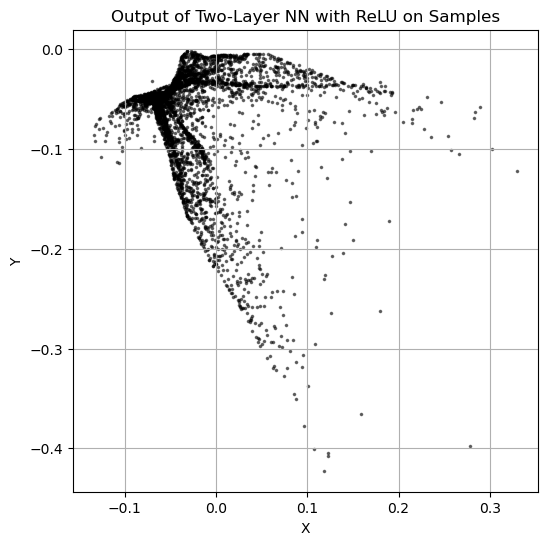

In [4]:
# Apply the neural network to the samples
y = nn_func_relu(X)

# Plot the output data points
plt.figure(figsize=(6, 6))
plt.scatter(y[:, 0].detach().numpy(), y[:, 1].detach().numpy(), alpha=0.5, s=10, c='black', marker='.')
plt.title('Output of Two-Layer NN with ReLU on Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

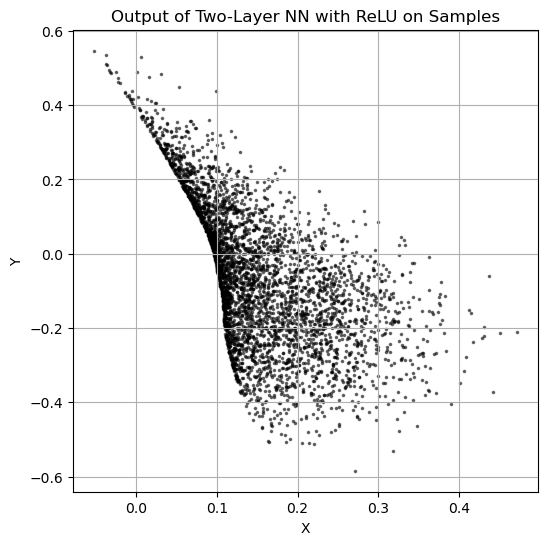

In [5]:
# Apply the neural network to the samples
y = nn_func_elu(X)

# Plot the output data points
plt.figure(figsize=(6, 6))
plt.scatter(y[:, 0].detach().numpy(), y[:, 1].detach().numpy(), alpha=0.5, s=10, c='black', marker='.')
plt.title('Output of Two-Layer NN with ReLU on Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

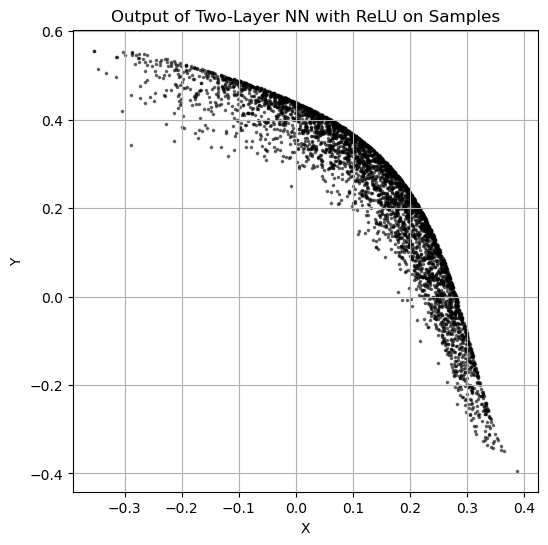

In [6]:
# Apply the neural network to the samples
y = nn_func_tanh(X)

# Plot the output data points
plt.figure(figsize=(6, 6))
plt.scatter(y[:, 0].detach().numpy(), y[:, 1].detach().numpy(), alpha=0.5, s=10, c='black', marker='.')
plt.title('Output of Two-Layer NN with ReLU on Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

In [7]:
# Define a target distribution: uniform distribution over four circles

def sample_pattern():
    centers = [(1.5, 1.5), (-1.5, 1.5), (-1.5, -1.5), (1.5, -1.5)]
    radius = 1
    min_x = min(c[0] for c in centers) - radius
    max_x = max(c[0] for c in centers) + radius
    min_y = min(c[1] for c in centers) - radius
    max_y = max(c[1] for c in centers) + radius

    # Generate a large number of random points within the bounding box
    num_points = 20000
    random_x = (max_x - min_x) * torch.rand(num_points, 1) + min_x
    random_y = (max_y - min_y) * torch.rand(num_points, 1) + min_y
    random_points = torch.cat((random_x, random_y), dim=1)

    flag = torch.zeros(num_points, dtype=torch.bool)
    for center in centers:
        diff = random_points - torch.tensor(center)[None, :]
        distance = torch.linalg.vector_norm(diff, dim=1)
        flag = torch.logical_or(distance <= radius, flag)

    y = random_points[flag]
    y = y[:4000,:]
    return y


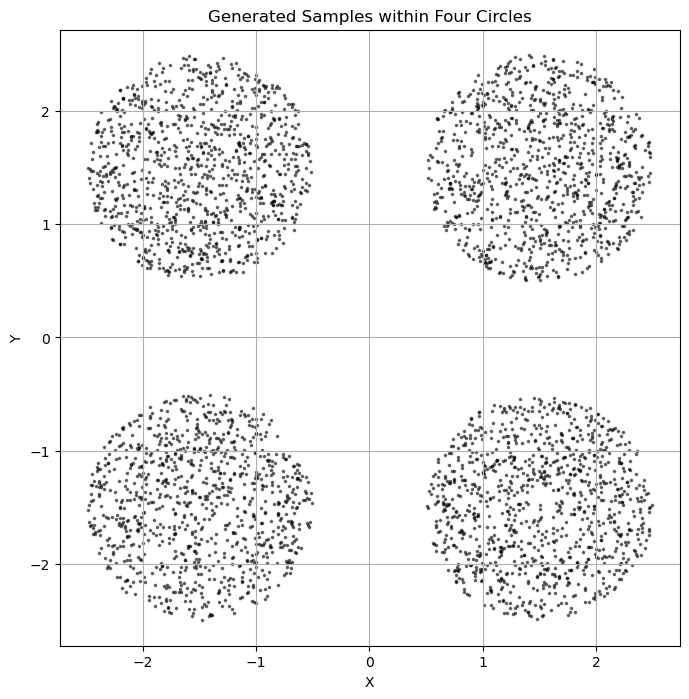

In [8]:
# draw samples from the target distribution
y = sample_pattern()


plt.figure(figsize=(8, 8))
plt.scatter(y[:, 0].detach().numpy(), y[:, 1].detach().numpy(), alpha=0.5, s=10, c='black', marker='.')
plt.title('Generated Samples within Four Circles')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.axis('equal')
plt.show()

In [9]:
def train_one_epoch(model, criterion, optimizer, dataloader):
    
    device = next(model.parameters()).device
    model.train()
    
    dataset_size = len(dataloader) * dataloader.batch_size if dataloader.drop_last else len(dataloader.dataset)
    running_loss = 0.0
    
    for x, y in dataloader:
        
        batch_size = len(x)
        
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += (batch_size / dataset_size) * loss.item()

    return running_loss

def evaluate(model, criterion, dataloader):

    device = next(model.parameters()).device
    model.eval()
    
    dataset_size = len(dataloader) * dataloader.batch_size if dataloader.drop_last else len(dataloader.dataset)
    running_loss = 0.0
    
    with torch.no_grad():
        for x, y in dataloader:

            batch_size = len(x)

            x, y = x.to(device), y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            running_loss += (batch_size / dataset_size) * loss.item()

    return running_loss


In [10]:
def rbf_kernel(x, y, sigma_list=[0.05, 0.1, 0.2]):
    L2_distance = ((x[:, None, :] - y[None, :, :]) ** 2).sum(-1)
    return torch.mean(torch.stack([torch.exp(-L2_distance / (2 * s**2)) for s in sigma_list]), dim=0)

class MMDLoss(torch.nn.Module):
    def __init__(self, kernel=rbf_kernel):
        super().__init__()
        self.kernel = kernel

    def forward(self, x, y, **kernel_kwargs):
        xx = self.kernel(x, x, **kernel_kwargs)
        yy = self.kernel(y, y, **kernel_kwargs)
        xy = self.kernel(x, y, **kernel_kwargs)
        mmd = xx.mean() + yy.mean() - 2 * xy.mean()
        return mmd

In [12]:
class ResampleDataset(torch.utils.data.Dataset):
    def __init__(self, y_target):
        self.y_target = y_target

    def __len__(self):
        return len(self.y_target)

    def __getitem__(self, idx):
        x = torch.randn(2)
        y = self.y_target[torch.randint(0, len(self.y_target), (1,)).item()]
        return x, y
    
train_dataset = ResampleDataset(y)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)

In [13]:
#TODO: instead of using the function "sample_pattern" above to get the distribution,
# Can you train the neural network, such that:
# y = nn_func_elu(X) can give you the same distribution?

# You need to show the distribution of transformed variables with newly sampled X.

# X = torch.randn(4000, 2)
# y = nn_func_elu(X)

lr = 0.001
num_epochs = 20_000

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

nn_func_elu = TwoLayerNN(input_dim=2, output_dim=2, activation="elu")
nn_func_elu.to(device)

criterion = MMDLoss()

optimizer = torch.optim.Adam(nn_func_elu.parameters(), lr=lr)

train_losses = []

for epoch in range(num_epochs):
    
    train_loss = train_one_epoch(nn_func_elu, criterion, optimizer, train_dataloader)
    
    train_losses.append(train_loss)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")


cuda:0
Epoch [100/20000], Loss: 0.0050
Epoch [200/20000], Loss: 0.0053
Epoch [300/20000], Loss: 0.0052
Epoch [400/20000], Loss: 0.0050
Epoch [500/20000], Loss: 0.0046
Epoch [600/20000], Loss: 0.0046
Epoch [700/20000], Loss: 0.0048
Epoch [800/20000], Loss: 0.0047
Epoch [900/20000], Loss: 0.0042
Epoch [1000/20000], Loss: 0.0043
Epoch [1100/20000], Loss: 0.0038
Epoch [1200/20000], Loss: 0.0037
Epoch [1300/20000], Loss: 0.0031
Epoch [1400/20000], Loss: 0.0026
Epoch [1500/20000], Loss: 0.0024
Epoch [1600/20000], Loss: 0.0021
Epoch [1700/20000], Loss: 0.0022
Epoch [1800/20000], Loss: 0.0021
Epoch [1900/20000], Loss: 0.0019
Epoch [2000/20000], Loss: 0.0020
Epoch [2100/20000], Loss: 0.0017
Epoch [2200/20000], Loss: 0.0018
Epoch [2300/20000], Loss: 0.0017
Epoch [2400/20000], Loss: 0.0016
Epoch [2500/20000], Loss: 0.0016
Epoch [2600/20000], Loss: 0.0017
Epoch [2700/20000], Loss: 0.0015
Epoch [2800/20000], Loss: 0.0015
Epoch [2900/20000], Loss: 0.0013
Epoch [3000/20000], Loss: 0.0014
Epoch [3100/

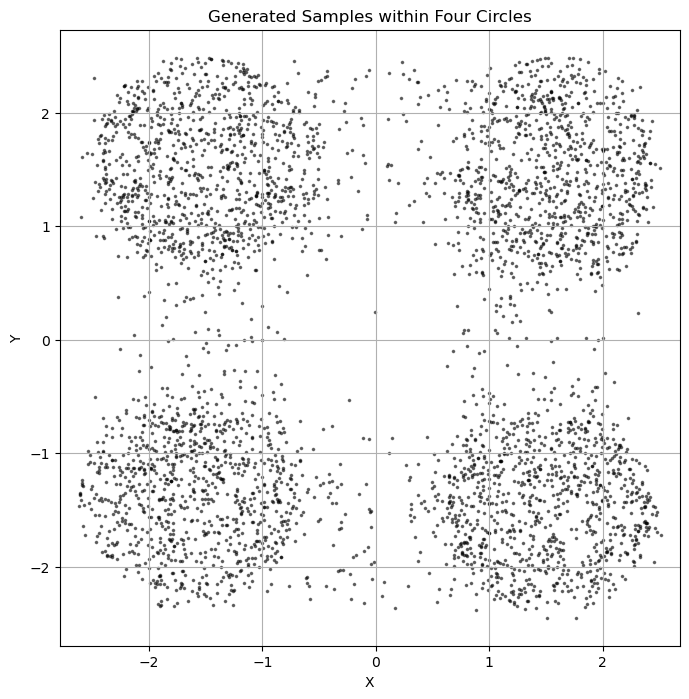

In [14]:
gen_X = torch.randn(4000, 2, device=device)
gen_y = nn_func_elu(gen_X).cpu()

plt.figure(figsize=(8, 8))
plt.scatter(gen_y[:, 0].detach().numpy(), gen_y[:, 1].detach().numpy(), alpha=0.5, s=10, c='black', marker='.')
plt.title('Generated Samples within Four Circles')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.axis('equal')s
plt.show()